In [7]:
import random

In [8]:
from transformers import AutoTokenizer, AutoModelForCausalLM


In [10]:
import torch
from torch import nn
import torch.nn.functional as F

from scipy.signal import lfilter

device = "cuda"

In [11]:
from transformers.models.gemma2.modeling_gemma2 import Gemma2DecoderLayer, Gemma2Config, Gemma2Attention

In [12]:

# Helper functions to count the number of parameters in a torch.nn.Module
def count_parameters(module):
    return sum(p.numel() for p in module.parameters())


def display_gpu_memory():
    # torch can give a more accurate memory usage than nvidia-smi
    for i in range(torch.cuda.device_count()):
        total_memory_gb = torch.cuda.get_device_properties(i).total_memory / (1024**3)
        allocated_memory_gb = torch.cuda.memory_allocated(i) / (1024**3)
        free_memory_gb = torch.cuda.mem_get_info(i)[0] / (1024**3)
        print(f"GPU {i}:")
        print(f"  Total GPU memory: {total_memory_gb:.1f} GB")
        print(f"  Free GPU memory: {free_memory_gb:.1f} GB")
        print(f"  Allocated GPU memory: {allocated_memory_gb:.1f} GB")


def parameter_count_string(module):
    n_params = count_parameters(module)
    if n_params > 10**6:
        return f"{n_params/10**6:.1f}M"
    elif n_params > 10**3:
        return f"{n_params/10**3:.1f}k"
    else:
        return f"{n_params}" 
    

In [13]:
class TokenDownsampler(nn.Module):
    def __init__(self, downsample_rate: float):
        super().__init__()
        self.downsample_rate = downsample_rate


class TokenUpsampler(nn.Module):
    def __init__(self, upsample_rate: float):
        super().__init__()
        self.upsample_rate = upsample_rate


def get_merge_dst(gate_samples: torch.Tensor) -> torch.Tensor:
    """
    Returns (merge_dst, dst_idx) the merge destination for each token in the sequence and the number of unique merge destinations.
    For now, has a janky python for-loop implementation.
    Input is a tensor of shape (batch_size, sequence_length) with 0 tokens are merged into the next 1 token.
    """
    batch_size, seq_len = gate_samples.shape
    merge_dst = torch.zeros_like(gate_samples, dtype=torch.long)
    n_dst = torch.zeros(batch_size, dtype=torch.long)

    # Process each batch separately
    for b in range(batch_size):
        dst_idx = 0
        for i in range(seq_len):
            merge_dst[b, i] = dst_idx
            if gate_samples[b, i] == 1 and i < seq_len - 1:
                # If previous position had gate=1, keep the same destination
                dst_idx += 1

        n_dst[b] = dst_idx + 1

    return merge_dst, n_dst


class AverageTokenDownsampler():
    def forward(self, x: torch.Tensor, gate_samples: torch.Tensor, position_ids: torch.Tensor) -> torch.Tensor:
        """
        1 2 3 4 5
        1 0 0 1 1
        ->
        1 3 5
        inputs:
        x.shape = (batch_size, seq_len, embedding_dim)
        gate_samples.shape = (batch_size, seq_len)
        position_ids.shape = (batch_size, seq_len)
        returns:
        x_downsampled.shape = (batch_size, n_dst, embedding_dim)
        position_ids_downsampled.shape = (batch_size, n_dst)
        """
        batch_size, _, _ = x.shape

        # Merge the tokens into the next token where the gate is 1.
        gate_samples = gate_samples.squeeze(-1)
        down_merge_dst, n_dst = get_merge_dst(gate_samples)

        # Also merge the position ids.
        position_ids_downsampled = torch.zeros(batch_size, n_dst.max(), dtype=x.dtype).to(x.device)
        position_ids_downsampled = torch.scatter_reduce(position_ids_downsampled, dim=1, index=down_merge_dst, src=position_ids, reduce="mean", include_self=False)

        # Merge the downsampled tokens.
        down_merge_dst = down_merge_dst.unsqueeze(-1).expand(-1, -1, self.embedding_dim)

        x_downsampled = torch.zeros(batch_size, n_dst.max(), self.embedding_dim, dtype=x.dtype).to(x.device)
        x_downsampled = torch.scatter_reduce(x_downsampled, dim=1, index=down_merge_dst, src=x, reduce="mean", include_self=False)

        return x_downsampled, position_ids_downsampled


class DistributeTokenUpsampler():
    def forward(self, x: torch.Tensor, gate_samples: torch.Tensor) -> torch.Tensor:
        """
        1 2 3
        1 0 0 1 1
        ->
        1 1 1 2 3
        inputs:
        x.shape = (batch_size, shortened_seq_len, embedding_dim)
        gate_samples.shape = (batch_size, seq_len)
        returns:
        x_upsampled.shape = (batch_size, seq_len, embedding_dim)
        """
        _, _, embedding_dim = x.shape

        # Get the merge destination for each token
        up_merge_dst, _ = get_merge_dst(gate_samples)
        up_merge_dst = up_merge_dst.unsqueeze(-1).expand(-1, -1, embedding_dim)

        # Add the upsampled deviation to the input to the middle layers
        x_upsampled = torch.gather(x, dim=1, index=up_merge_dst)

        return x_upsampled


def get_gate_indices(gate_samples: torch.Tensor, n_dst_max) -> torch.Tensor:
    """
    Returns the indices of the tokens that are gated merged. For now, has a janky python for-loop implementation.
    """
    batch_size, seq_len = gate_samples.shape
    gate_indices = torch.zeros(batch_size, n_dst_max, dtype=torch.long)

    # Process each batch separately
    for b in range(batch_size):
        dst_idx = 0
        for i, _ in enumerate(gate_samples[b]):
            if gate_samples[b, i] == 1:
                gate_indices[b, dst_idx] = i
                dst_idx += 1

    return gate_indices


class SelectTokenDownsampler():
    def forward(self, x: torch.Tensor, gate_samples: torch.Tensor, position_ids: torch.Tensor) -> torch.Tensor:
        """
        1 2 3 4 5
        1 0 0 1 1
        ->
        1 4 5
        inputs:
        x.shape = (batch_size, seq_len, embedding_dim)
        gate_samples.shape = (batch_size, seq_len)
        position_ids.shape = (batch_size, seq_len)
        returns:
        x_downsampled.shape = (batch_size, n_dst, embedding_dim)
        position_ids_downsampled.shape = (batch_size, n_dst)
        """

        batch_size, seq_len, _ = x.shape

        # Merge the tokens into the next token where the gate is 1.
        gate_samples = gate_samples.squeeze(-1)
        n_dst = gate_samples.sum(dim=1)

        selected_indices = get_gate_indices(gate_samples, n_dst.max())
        position_ids_downsampled = position_ids.gather(dim=1, index=selected_indices)

        selected_indices = selected_indices.unsqueeze(-1).expand(-1, -1, x.shape[-1])
        x_downsampled = x.gather(dim=1, index=selected_indices)

        return x_downsampled, position_ids_downsampled


In [14]:
def test_select_token_downsampler():
    x = torch.randn(2, 5, 1)
    gate_samples = torch.tensor(
        [
            [1, 1, 0, 0, 1],
            [1, 0, 0, 1, 1]
        ]
    )
    my_position_ids = torch.arange(5).unsqueeze(0).expand(2, -1)
    SelectTokenDownsampler().forward(x, gate_samples, my_position_ids)

test_select_token_downsampler()

In [15]:
def compute_discounted_rewards(rewards, discount):
    """
    Assumes that rewards is a numpy array of shape (n_episodes, n_timesteps). Returns tensor of same shape.
    credit to: https://stackoverflow.com/questions/47970683/vectorize-a-numpy-discount-calculation/47971187#47971187,
    minor modifications made to vectorise computation.
    C[i] = R[i] + discount * C[i+1]
    signal.lfilter(b, a, x, axis=-1, zi=None)
    a[0]*y[n] = b[0]*x[n] + b[1]*x[n-1] + ... + b[M]*x[n-M]
                          - a[1]*y[n-1] - ... - a[N]*y[n-N]
    """
    r = rewards[:, ::-1]
    a = [1, -discount]
    b = [1]
    y = lfilter(b, a, x=r)
    return y[:, ::-1]


def discounted_rewards_torch(rewards, discount):
    """torch wrapper for compute_discounted_rewards. Warning: does _not_ allow for backprop through the rewards, which is fine for policy gradients."""
    rewards_device = rewards.device
    rewards = rewards.detach().cpu().numpy()
    discounted_rewards = compute_discounted_rewards(rewards, discount)
    discounted_rewards = torch.tensor(discounted_rewards.copy(), device=rewards_device) # Copy as torch doesn't like converting negatively strided arrays
    return discounted_rewards


class DownGater(nn.Module):
    def __init__(self, embedding_dim: int, downsample_rate: float):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.downsample_rate = downsample_rate

    def gate_samples(self, down_gate_probs: torch.Tensor) -> torch.Tensor:
        gate_samples = torch.bernoulli(down_gate_probs)
        return gate_samples


class LinearGater(nn.Module):
    def __init__(self, embedding_dim: int, downsample_rate: float):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.linear = nn.Linear(embedding_dim, 1)
        self.downsample_rate = downsample_rate
        self.downsample_rate_scale = 5.

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        down_gate_logits = self.linear(x)
        down_gate_probs = F.sigmoid(down_gate_logits)
        return down_gate_logits, down_gate_probs # We need to return the logits for stable backprop
    

class RandomGater(nn.Module):
    def __init__(self, embedding_dim: int, downsample_rate: float):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.downsample_rate = downsample_rate

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size, seq_len, _ = x.shape
        gate_probs = torch.ones(batch_size, seq_len, 1, dtype=x.dtype, device=x.device) * self.downsample_rate
        gate_logits = torch.log(gate_probs / (1 - gate_probs))
        return gate_logits, gate_probs


class EquidistantGater(nn.Module):
    def __init__(self, embedding_dim: int, downsample_rate: float):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.downsample_rate = downsample_rate
        self.gate_every = round(1 / downsample_rate)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size, seq_len, _ = x.shape
        gate_probs = torch.zeros(batch_size, seq_len, 1, dtype=x.dtype, device=x.device) 
        gate_probs[:, ::self.gate_every] = 1.
        gate_logits = gate_probs * 40. - 20. # Avoid Nans
        return gate_logits, gate_probs

In [16]:
def test_gaters():
    x = torch.randn(2, 5, 3)
    RandomGater(3, 0.25).forward(x)
    print(f"{LinearGater(3, 0.25).forward(x)[0].shape=}")
    EquidistantGater(3, 0.25).forward(x)

test_gaters()
    

LinearGater(3, 0.25).forward(x)[0].shape=torch.Size([2, 5, 1])


In [17]:
from transformers import AutoTokenizer
from torch import nn
from typing import List

from copy import deepcopy
import torch

import numpy as np

import pandas as pd

from torch.utils.data import DataLoader

import datasets


class GemmaMiniBitterLLM(nn.Module):
    # A mini BitterLLM with 2 down, 4 mid, and 2 up layers. As a vibe check on the idea.
    # Use Gemma2DecoderLayer as a drop in replacement for the TransformerEncoderLayer, with RoPE and sliding window pre-implemented.
    # Also uses 
    def __init__(self, vocab_size: int, embedding_dim: int, num_heads: int, downsample_rate: float = 0.25, sliding_window = 64, GaterClass=LinearGater):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        head_dim = embedding_dim // num_heads

        byte_layer_config = Gemma2Config(
            head_dim=head_dim,
            query_pre_attn_scalar=head_dim, 
            sliding_window=sliding_window,
            intermediate_size=embedding_dim,
            hidden_size=embedding_dim,
            num_attention_heads=num_heads,
            num_key_value_heads=num_heads,
        )

        deep_layer_config = Gemma2Config(
            head_dim=head_dim,
            query_pre_attn_scalar=head_dim, 
            sliding_window=None,
            intermediate_size=embedding_dim * 4, # dim_feedforward should scale inversely with the number of tokens in the sequence.
            hidden_size=embedding_dim,
            num_attention_heads=num_heads,
            num_key_value_heads=num_heads
        )

        
        # Layer idx=0 is necessary for the sliding window to be applied.
        self.down_layers = nn.ModuleList([
            Gemma2DecoderLayer(byte_layer_config, layer_idx=0) for _ in range(2)
        ])

        self.mid_layers = nn.ModuleList([
            Gemma2DecoderLayer(deep_layer_config, layer_idx=1) for _ in range(2) 
        ])

        self.up_layers = nn.ModuleList([
            Gemma2DecoderLayer(byte_layer_config, layer_idx=0) for _ in range(2)
        ])

        self.output_layer = nn.Linear(embedding_dim, vocab_size)
        
        self.down_layer_gate = GaterClass(embedding_dim, downsample_rate)
        self.downsample_rate = downsample_rate


    def forward(self, x: torch.Tensor) -> torch.Tensor:

        batch_size, max_seq_len = x.shape


        x = self.embedding(x)

        position_ids = torch.arange(max_seq_len, dtype=x.dtype).unsqueeze(0).expand(batch_size, -1).to(x.device)

        # Apply down layers to byte tokens        
        for layer in self.down_layers:
            x = layer(x, position_ids=position_ids)[0]

        # Sample gating binary variables for each token.
        down_gate_logits, down_gate_probs = self.down_layer_gate(x)
        down_gate_samples = torch.bernoulli(down_gate_probs)

        # Hack: ensure for now that we always gate on the first token:
        down_gate_samples[:, 0] = 1.

        # Merge the tokens into the next token where the gate is 1.
        down_gate_samples = down_gate_samples.squeeze(-1)
        down_merge_dst, n_dst = get_merge_dst(down_gate_samples)

        # Also merge the position ids.
        position_ids_downsampled = torch.zeros(batch_size, n_dst.max(), dtype=x.dtype).to(x.device)
        position_ids_downsampled = torch.scatter_reduce(position_ids_downsampled, dim=1, index=down_merge_dst, src=position_ids, reduce="mean", include_self=False)

        # Merge the downsampled tokens.
        down_merge_dst = down_merge_dst.unsqueeze(-1).expand(-1, -1, self.embedding_dim)

        x_downsampled = torch.zeros(batch_size, n_dst.max(), self.embedding_dim, dtype=x.dtype).to(x.device)
        x_downsampled = torch.scatter_reduce(x_downsampled, dim=1, index=down_merge_dst, src=x, reduce="mean", include_self=False)

        # Apply mid layers to merged tokens and compute the deviation
        for layer in self.mid_layers:
            y_downsampled = layer(x_downsampled, position_ids=position_ids_downsampled)[0]
            deviation = y_downsampled - x_downsampled        

        # Upsample by removing the first token merge group, shifting all token groups down and adding another one token group at the end.
        up_gate_samples = down_gate_samples[:, 1:]
        up_gate_samples = torch.cat([up_gate_samples, torch.ones(batch_size, 1, dtype=up_gate_samples.dtype).to(up_gate_samples.device)], dim=1)
        up_merge_dst, _ = get_merge_dst(up_gate_samples)
        up_merge_dst = up_merge_dst.unsqueeze(-1).expand(-1, -1, self.embedding_dim)

        # Add the upsampled deviation to the input to the middle layers
        upsampled_deviation = torch.gather(deviation, dim=1, index=up_merge_dst)
        y = x + upsampled_deviation

        # Apply up layers to byte tokens
        for layer in self.up_layers:
            y = layer(y, position_ids=position_ids)[0]

        # Map residual stream to logits
        logits = self.output_layer(y)
        logits = F.log_softmax(logits, dim=-1)

        out = {
            "logits": logits,
            "down_gate_probs": down_gate_probs.squeeze(-1),
            "down_gate_logits": down_gate_logits.squeeze(-1),
            "down_gate_samples": down_gate_samples.to(dtype=torch.long),
            "down_merge_dst": down_merge_dst[:, :, 0], # This dimension is repeated.
            "up_merge_dst": up_merge_dst[:, :, 0],
            "n_dst": n_dst,
        }

        return out

In [18]:
upper_patterns = ["10110", "0010"]
lower_patterns = ["ABA", "BBAAB"]

imputed_upper_patterns = [
    p.replace("0", lower_patterns[0]).replace("1", lower_patterns[1]) for p in upper_patterns
]
imputed_upper_patterns

['BBAABABABBAABBBAABABA', 'ABAABABBAABABA']

In [19]:
def sample(n_upper):
    choices = [random.randint(0, 1) for _ in range(n_upper)]

    x = "".join(
        imputed_upper_patterns[c] for c in choices
    )
    return x, choices


In [64]:
my_txt, my_c = sample(20)
my_txt

'ABAABABBAABABABBAABABABBAABBBAABABABBAABABABBAABBBAABABABBAABABABBAABBBAABABABBAABABABBAABBBAABABAABAABABBAABABAABAABABBAABABABBAABABABBAABBBAABABAABAABABBAABABABBAABABABBAABBBAABABABBAABABABBAABBBAABABABBAABABABBAABBBAABABABBAABABABBAABBBAABABABBAABABABBAABBBAABABABBAABABABBAABBBAABABABBAABABABBAABBBAABABABBAABABABBAABBBAABABAABAABABBAABABAABAABABBAABABAABAABABBAABABA'

In [67]:
my_c


elongated_upper_patterns = [
    p.replace("0", "0" * len(lower_patterns[0])).replace("1", "1" * len(lower_patterns[1])) for p in upper_patterns
]

elongated_upper_patterns

def distribute_choices(choices):
    return "".join(
        elongated_upper_patterns[c] for c in choices
    )

distribute_choices(my_c)


'00000011111000111110001111111111000111110001111111111000111110001111111111000111110001111111111000000000111110000000001111100011111000111111111100000000011111000111110001111111111000111110001111111111000111110001111111111000111110001111111111000111110001111111111000111110001111111111000111110001111111111000111110001111111111000000000111110000000001111100000000011111000'

In [21]:
# Idea: force MiniBitterLM to learn these strings, with a context window of 4 for the initial tokens.
# In theory, there should be less than 2 / (6 + 4) * (4 + 6) = 1/50 bits per character.

In [22]:
def sample_dataset(n_samples):
    x_vals = []
    c_vals = []

    for _ in range(n_samples):
        x, c = sample(20)
        x_vals.append(x)
        c_vals.append(c)

    return x_vals, c_vals


In [23]:
train_x, train_c = sample_dataset(10**5)
val_x, val_c = sample_dataset(10**4)

In [25]:
byte5_tokenizer = AutoTokenizer.from_pretrained("google/byt5-large")

In [35]:
from experiment_5 import CausalGemmaMiniBitterLLM, bitter_tokenizer_training_step, display_gating

In [36]:
my_model = CausalGemmaMiniBitterLLM(vocab_size=byte5_tokenizer.vocab_size, embedding_dim=256, num_heads=8, downsample_rate=0.25, sliding_window=4, GaterClass=LinearGater)
print(f"my_model has {parameter_count_string(my_model)} parameters")
my_model

my_model has 4.1M parameters


CausalGemmaMiniBitterLLM(
  (embedding): Embedding(256, 256)
  (down_layers): ModuleList(
    (0-1): 2 x Gemma2DecoderLayer(
      (self_attn): Gemma2Attention(
        (q_proj): Linear(in_features=256, out_features=256, bias=False)
        (k_proj): Linear(in_features=256, out_features=256, bias=False)
        (v_proj): Linear(in_features=256, out_features=256, bias=False)
        (o_proj): Linear(in_features=256, out_features=256, bias=False)
        (rotary_emb): Gemma2RotaryEmbedding()
      )
      (mlp): Gemma2MLP(
        (gate_proj): Linear(in_features=256, out_features=256, bias=False)
        (up_proj): Linear(in_features=256, out_features=256, bias=False)
        (down_proj): Linear(in_features=256, out_features=256, bias=False)
        (act_fn): PytorchGELUTanh()
      )
      (input_layernorm): Gemma2RMSNorm((256,), eps=1e-06)
      (pre_feedforward_layernorm): Gemma2RMSNorm((256,), eps=1e-06)
      (post_feedforward_layernorm): Gemma2RMSNorm((256,), eps=1e-06)
      (post

In [39]:

def bitter_tokenizer_training_step(model, batch, optimizer, learn_gating=True):
    """
    Assume that batch is torch.tensor of token ids of shape (batch, sequence_length). returns a dict of floats of the training losses for the batch.
    """
    batch_size, _ = batch.shape

    optimizer.zero_grad()

    out = model(batch)
    logits = out["logits"]
    down_gate_samples = out["down_gate_samples"]
    down_gate_probs = out["down_gate_probs"]
    down_gate_logits = out["down_gate_logits"]
    
    # Compute autoregressive loss: log probability of next token.
    next_token_ids = batch[:, 1:]
    current_token_logits = logits[:, :-1]
    next_token_logits = F.cross_entropy(current_token_logits.transpose(1, 2), next_token_ids, reduction="none") # Transpose as F.cross_entropy wants shape [batch, classes, ...]
    ar_loss = next_token_logits.mean()
    true_downsample_rate = down_gate_probs.mean()

    if learn_gating:
        # Compute gating loss: discounted log probabilities of following token(s).
        discount_rate = 0.99
        next_token_logits_padded = torch.cat([next_token_logits, torch.zeros(batch_size, 1, device=next_token_logits.device)], dim=-1) # Pad the last reward as zero
        discounted_rewards = discounted_rewards_torch(next_token_logits_padded, discount_rate)
        discounted_rewards = (discounted_rewards - discounted_rewards.mean(dim=0)) # Simple estimate of the advantage

        # action 0 = continue, action 1 = gate
        action_log_probs = torch.stack([torch.zeros_like(down_gate_logits), down_gate_logits], dim=1) # As a sigmoid is equivalent to having one logit as 0.
        selected_action_log_probs = F.cross_entropy(action_log_probs, down_gate_samples, reduction="none")
        gating_loss = - (discounted_rewards * selected_action_log_probs).mean() # Negative as we want to maximise the reward.

        # Hacky additional consistency loss: make the downsampling rate match the training gating.
        down_gate_rate_loss =  4.*(model.downsample_rate - true_downsample_rate) **2

        total_loss = ar_loss + gating_loss + down_gate_rate_loss
    else:
        selected_action_log_probs = torch.tensor(0.0)
        gating_loss = torch.tensor(0.0)
        down_gate_rate_loss = torch.tensor(0.0) # For logging purposes.
        total_loss = ar_loss

    # Optimizer step
    total_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()

    out = {
        "ar_loss": ar_loss.item(),
        "gating_loss": gating_loss.item(),
        "true_downsample_rate": true_downsample_rate.item(),
        "rate_consistency_loss": down_gate_rate_loss.item(),
        "total_loss": total_loss.item(),
        "selected_action_ce": selected_action_log_probs.mean().item()
    }

    return out


In [44]:

def bitter_tokenizer_training_loop(model, train_dataset, batch_print_every=10, num_epochs=1, batch_size=128, batch_limit=None, learn_gating=True):
    # TODO: validation dataset
    # Create data loaders
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )

    # See how the model merges a sequence.
    test_string = train_dataset[-1][:200]
    test_batch = byte5_tokenizer.encode(test_string, return_tensors="pt", padding=True).to(device)

    # Initialize model and optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    
    train_losses = []

    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        model = model.to(device)

        print(f"Epoch {epoch+1}/{num_epochs}, GPU usage:")
        display_gpu_memory()

        for batch_count, batch in enumerate(train_loader):

            batch = byte5_tokenizer(batch, return_tensors="pt", padding=True)["input_ids"]
            batch = batch[:, :1024]  # Truncate to maximum length of 4096 to save GPU memory.
            batch = batch.to(device)

            loss_dict = bitter_tokenizer_training_step(model, batch, optimizer, learn_gating=learn_gating)
            train_losses.append(loss_dict)

            # Memory tracking for each batch
            if batch_count % batch_print_every == 0:
                print(f"Batch {batch_count} ar train loss: {loss_dict['ar_loss']:.4f} nats/token selected action ce: {loss_dict['selected_action_ce']}")
                true_rate = loss_dict["true_downsample_rate"]
                implied_iid_ce = -true_rate * np.log(true_rate) - (1 - true_rate) * np.log(1 - true_rate)
                print(f"Downsample rate: {true_rate:4f} implied iid ce: {implied_iid_ce:4f}")


                with torch.no_grad():
                    out = model(test_batch)

                gate_samples = out["down_gate_samples"]
                merge_dst = out["down_merge_dst"]
                display_gating(test_batch[0], merge_dst[0])

                if batch_limit is not None and batch_count > batch_limit:
                    break

        # Print metrics
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train loss: {np.mean([l['total_loss'] for l in train_losses]):.4f}")
    
    train_losses = pd.DataFrame(train_losses)

    return train_losses


In [45]:
train_losses = bitter_tokenizer_training_loop(my_model, train_x, num_epochs=1, batch_size=256, batch_print_every=1, batch_limit=250, learn_gating=True)
train_losses

Epoch 1/1, GPU usage:
GPU 0:
  Total GPU memory: 79.2 GB
  Free GPU memory: 22.7 GB
  Allocated GPU memory: 30.5 GB
Batch 0 ar train loss: 0.9154 nats/token selected action ce: 0.10038264095783234
Downsample rate: 0.271732 implied iid ce: 0.584974
A|BA|A|BA|BBAABA|BAA|BA|A|BA|BBAABA|BABBAABA|BABBAABBBAABA|BAA|BA|A|BABBAABA|BAA|BA|A|BA|BBAABA|BAA|BA|A|BA|BBAABA|BAA|BA|A|BA|BBAABA|BAA|BA|A|BA|BBAABA|BABBAABA|BABBAABBBAABABABBAABA|BABBAABBBAABA|BABBAABA|BABBAABBBAABA|BABBAABA|BABBAABBBAAB</s>
Batch 1 ar train loss: 0.0854 nats/token selected action ce: 0.09253907203674316
Downsample rate: 0.274525 implied iid ce: 0.587708
A|BA|A|BA|BBAABA|BAA|BA|A|BA|BBAABA|BABBAABABABBAABBBAABA|BAA|BA|A|BA|BBAABABAA|BA|A|BA|BBAABA|BAA|BA|A|BA|BBAABABAA|BA|A|BA|BBAABA|BAA|BA|A|BA|BBAABA|BABBAABA|BABBAABBBAABA|BABBAABA|BABBAABBBAABA|BABBAABA|BABBAABBBAABA|BABBAABA|BABBAABBBAAB</s>
Batch 2 ar train loss: 0.5530 nats/token selected action ce: 0.10298364609479904
Downsample rate: 0.288809 implied iid ce: 0.60

,ar_loss,gating_loss,true_downsample_rate,rate_consistency_loss,total_loss,selected_action_ce
0,0.915433,0.169230,0.271732,1.889135e-03,1.086552,0.100383
1,0.085403,-0.005503,0.274525,2.405964e-03,0.082306,0.092539
2,0.553016,0.050894,0.288809,6.024573e-03,0.609935,0.102984
3,0.520976,0.004078,0.265035,9.041587e-04,0.525959,0.103126
4,0.295334,0.026724,0.283837,4.579639e-03,0.326637,0.110299
...,...,...,...,...,...,...
247,0.034875,-0.028780,0.258856,3.136832e-04,0.006409,0.137215
248,0.035424,-0.030959,0.249781,1.922138e-07,0.004465,0.125100
249,0.034636,-0.030122,0.262737,6.489314e-04,0.005163,0.135636
250,0.034582,-0.028114,0.252721,2.961043e-05,0.006498,0.149362


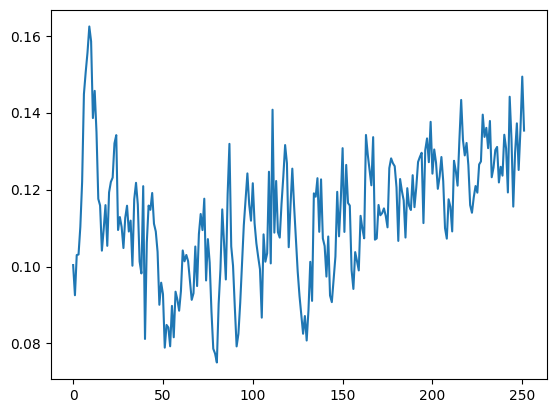

In [46]:
import matplotlib.pyplot as plt
plt.plot(train_losses["selected_action_ce"])

tensor([[69, 69, 68, 68, 69, 68, 69, 68, 69, 69, 68, 68, 69, 69, 69, 68, 68, 69,
         68, 69, 68, 68, 69, 68, 68, 69, 68, 69, 69, 68, 68, 69, 68, 69, 68, 69,
         69, 68, 68, 69, 68, 69, 68, 69, 69, 68, 68, 69, 69, 69, 68, 68, 69, 68,
         69, 68, 69, 69, 68, 68, 69, 68, 69, 68, 69, 69, 68, 68, 69, 69, 69, 68,
         68, 69, 68, 69, 68, 68, 69, 68, 68, 69, 68, 69, 69, 68, 68, 69, 68, 69,
         68, 68, 69, 68, 68, 69, 68, 69, 69, 68, 68, 69, 68, 69, 68, 68, 69, 68,
         68, 69, 68, 69, 69, 68, 68, 69, 68, 69, 68, 69, 69, 68, 68, 69, 68, 69,
         68, 69, 69, 68, 68, 69, 69, 69, 68, 68, 69, 68, 69, 68, 68, 69, 68, 68,
         69, 68, 69, 69, 68, 68, 69, 68, 69, 68, 69, 69, 68, 68, 69, 68, 69, 68,
         69, 69, 68, 68, 69, 69, 69, 68, 68, 69, 68, 69, 68, 69, 69, 68, 68, 69,
         68, 69, 68, 69, 69, 68, 68, 69, 69, 69, 68, 68, 69, 68, 69, 68, 68, 69,
         68, 68, 69, 68, 69, 69, 68, 68, 69, 68, 69, 68, 69, 69, 68, 68, 69, 68,
         69, 68, 69, 69, 68,

In [88]:
# Create a colormap from blue (low probability) to red (high probability)
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from IPython.display import HTML


In [91]:

# Helper function: plot where the model puts high probability gates.
def plot_gate_probs(txt, gate_probs):
    
    # Ensure gate_probs and input_text have the same length
    gate_probs = gate_probs[:len(txt)]
    
    # Create HTML with colored text based on probabilities
    colored_text = ""
    colorbar = ""
    
    # Create a colorbar showing the gradient
    for i in range(11):  # 0.0 to 1.0 in steps of 0.1
        prob = i / 10
        r = min(1.0, prob)
        b = max(0.0, 1.0 - prob)
        color = f"rgb({int(r*255)}, 0, {int(b*255)})"
        white = f"rgb(255, 255, 255)"
        colorbar += f'<span style="color:{white}; background-color:{color}; margin-right:2px; padding:0 5px;">{prob:.1f}</span>'
    
    # Add a legend for the colorbar
    colorbar_html = f'''
    <div style="margin-bottom:10px;">
        <div style="font-family:monospace; font-size:12px; margin-bottom:3px;">Probability: Low → High</div>
        <div style="font-family:monospace; font-size:14px;">{colorbar}</div>
    </div>
    '''
    
    # Process the text with colors
    for char, prob in zip(txt, gate_probs):
        # Convert probability to color (blue->red)
        r = min(1.0, prob)  # Red increases with probability
        b = max(0.0, 1.0 - prob)  # Blue decreases with probability
        color = f"rgb({int(r*255)}, 0, {int(b*255)})"
        # Add the colored character to the output
        colored_text += f'<span style="color:{color};">{char}</span>'
    
    # Display the colorbar and colored text
    display(HTML(f'''
    <div>
        {colorbar_html}
        <div style="font-family:monospace; font-size:14px;">{colored_text}</div>
    </div>
    '''))
    

In [94]:
my_txt, my_c = sample(20)
len(my_txt), my_txt
# my_gate_probs = my_model(my_batch)["down_gate_probs"][0].cpu().detach().numpy()
my_batch = byte5_tokenizer(my_txt, return_tensors="pt", padding=True, add_special_tokens=True).to(device)["input_ids"]
out = my_model(my_batch)
my_gate_probs = out["down_gate_probs"][0].cpu().detach().numpy()

In [95]:
plot_gate_probs(my_txt, my_gate_probs)

In [96]:
my_c_distributed = distribute_choices(my_c)
plot_gate_probs(my_c_distributed, my_gate_probs)

In [80]:
out["logits"].argmax(dim=-1)

tensor([[68, 68, 68, 69, 68, 69, 68, 69, 69, 68, 68, 69, 69, 69, 68, 68, 69, 68,
         69, 68, 69, 69, 68, 68, 69, 68, 69, 69, 68, 68, 69, 68, 69, 68, 69, 69,
         68, 68, 69, 68, 69, 68, 69, 69, 68, 68, 69, 69, 69, 68, 68, 69, 68, 69,
         68, 69, 69, 68, 68, 69, 68, 69, 69, 68, 68, 69, 68, 69, 68, 69, 69, 68,
         68, 69, 68, 69, 68, 69, 69, 68, 68, 69, 69, 69, 68, 68, 69, 68, 69, 68,
         69, 69, 68, 68, 69, 68, 69, 68, 69, 69, 68, 68, 69, 69, 69, 68, 68, 69,
         68, 69, 68, 69, 69, 68, 68, 69, 68, 69, 68, 69, 69, 68, 68, 69, 69, 69,
         68, 68, 69, 68, 69, 68, 69, 69, 68, 68, 69, 68, 69, 69, 68, 68, 69, 68,
         69, 68, 69, 69, 68, 68, 69, 68, 69, 69, 68, 68, 69, 68, 69, 68, 69, 69,
         68, 68, 69, 68, 69, 69, 68, 68, 69, 68, 69, 68, 69, 69, 68, 68, 69, 68,
         69, 68, 69, 69, 68, 68, 69, 69, 69, 68, 68, 69, 68, 69, 68, 69, 69, 68,
         68, 69, 68, 69, 69, 68, 68, 69, 68, 69, 68, 69, 69, 68, 68, 69, 68, 69,
         69, 68, 68, 69, 68,

In [75]:
my_c

[1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]

(array([280.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,  70.]),
 array([1.18410582e-21, 9.99999493e-02, 1.99999899e-01, 2.99999863e-01,
        3.99999797e-01, 4.99999762e-01, 5.99999726e-01, 6.99999690e-01,
        7.99999595e-01, 8.99999559e-01, 9.99999523e-01]),
 <BarContainer object of 10 artists>)

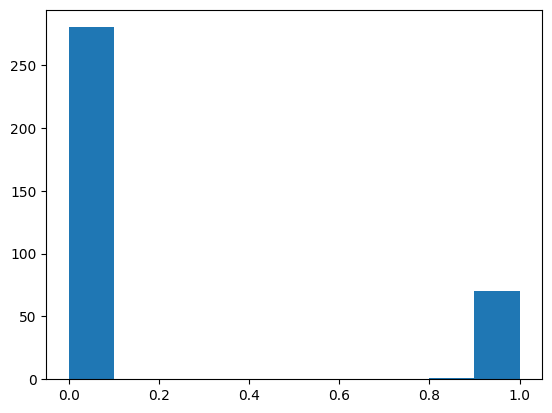

In [76]:
plt.hist(my_gate_probs)

In [ ]:
random_gating_model = GemmaMiniBitterLLM(vocab_size=byte5_tokenizer.vocab_size, embedding_dim=64, num_heads=4, downsample_rate=0.25, sliding_window=4, GaterClass=RandomGater)
print(f"random_gating_model has {parameter_count_string(random_gating_model)} parameters")

In [ ]:
random_gating_train_losses = bitter_tokenizer_training_loop(random_gating_model, train_x, num_epochs=1, batch_size=256, batch_print_every=1, batch_limit=200, learn_gating=False)
random_gating_train_losses 